# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="Images/pic1.png"/>

Then you will want to run the above command:

<img src="Images/pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
#Importing everything we'll need

#General Packages
import math
import json
import os
import datetime

#PyData Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

#Sklearn Packages
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, Imputer
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

#Magic Commands
%matplotlib inline

In [2]:
#Reading in the json files
portfolio = pd.read_json('data/portfolio.json', orient = 'records', lines = True)
profile = pd.read_json('data/profile.json', orient = 'records', lines = True)
transcript = pd.read_json('data/transcript.json', orient = 'records', lines = True)

### Initial Analysis & Data Preproccesing
###### With our packages and data imported, we'll move on by performing a lightweight analysis on the dataset to determine what pieces need preprocessed before we move on into the next section. We'll do this for each of our three datasets.

In [3]:
#Looking at the first fiew rows of the portfolio dataset
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [5]:
portfolio['offer_type'].value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

In [6]:
#Viewing all the channels leveraged
portfolio['channels'].value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[web, email, mobile, social]    4
[web, email, mobile]            3
[email, mobile, social]         2
[web, email]                    1
Name: channels, dtype: int64


##### Portfolio Clean Up

Since this is a relatively small dataset, there isn't much to  change. That said, we'll clean up these pieces here:

- Change the column name from 'id' to the more descriptive 'offer_id' since the id column is present in our other datasets
    
- One hot encode the 'offer_type' column to work well with our algorithms later
   
- Separate and one hot encode the 'channels' column to also work with our algorithms later

- Drop 'offer_type' and 'channels' columns now that they are one hot encoded



In [7]:
#Changing the column name from 'id' to 'offer_id'
portfolio.rename(columns = {'id': 'offer_id'}, inplace = True)
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   offer_id    10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [8]:
#One-hot encoding the offer_type field, fixing a prefix of 'offer'
offer_dummies = pd.get_dummies(portfolio['offer_type'], prefix = 'offer')
portfolio = pd.concat([portfolio,offer_dummies], axis = 1)

#After the changes
portfolio.head()

,reward,channels,difficulty,duration,offer_type,offer_id,offer_bogo,offer_discount,offer_informational
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,0,0,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0


In [9]:
#One-hot encoding thw channels field
#Please refer to this post on how to onecode multilabel a column : https://chrisalbon.com/machine_learning/preprocessing_structured_data/one-hot_encode_features_with_multiple_labels

#First initialize the MultiBinarizer Object 
one_hot_channels = MultiLabelBinarizer()

#One hot code the portfolio channel data
seperate_channel = one_hot_channels.fit_transform(portfolio['channels'])

#Making a Dataframe with new channels 
channels_df = pd.DataFrame(data = seperate_channel, columns = one_hot_channels.classes_)

#Concatenating the new columns with the old portfolio DataFrame
portfolio = pd.concat([portfolio,channels_df], axis = 1)

#Fixing the channels prefix in the column names
portfolio.rename(columns = {'email': 'channel_email', 'mobile': 'channel_mobile', 'social': 'channel_social', 'web': 'channel_web'}, inplace = True)

#After the changes
portfolio.head()

,reward,channels,difficulty,duration,offer_type,offer_id,offer_bogo,offer_discount,offer_informational,channel_email,channel_mobile,channel_social,channel_web
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,1,1,1,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,0,0,1,1,1,0,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,1,1,0,1
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1,0,0,1


In [10]:
#Dropping the now former 'channels' and 'offer_type' columns
portfolio.drop(columns = ['channels', 'offer_type'], axis = 1, inplace = True)

#Viewing our hanges
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   reward               10 non-null     int64 
 1   difficulty           10 non-null     int64 
 2   duration             10 non-null     int64 
 3   offer_id             10 non-null     object
 4   offer_bogo           10 non-null     uint8 
 5   offer_discount       10 non-null     uint8 
 6   offer_informational  10 non-null     uint8 
 7   channel_email        10 non-null     int32 
 8   channel_mobile       10 non-null     int32 
 9   channel_social       10 non-null     int32 
 10  channel_web          10 non-null     int32 
dtypes: int32(4), int64(3), object(1), uint8(3)
memory usage: 638.0+ bytes


### Profile Dataset

##### Initial Analysis

In [11]:
# Looking at some random rows
profile.head() 

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [12]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [13]:
#Checking gender types and leaving in the nulls
profile['gender'].value_counts(dropna = False)

M      8484
F      6129
NaN    2175
O       212
Name: gender, dtype: int64

In [14]:
#Checking how many unknown ages (118) are in the dataset
(profile['age'] == 118).sum()

2175


##### Profile Clean Up

Because this dataset is bigger, we'll have to make some more changes to it than our previous datasets. These changes include the following:

- Dropping rows with null information
- Changing 'id' column to 'customer_id' name
- Changing the 'became_member_on' column to a date object type
- Calculating number of days that a person has been a member as new 'days_as_member' column as of August 1, 2018
- Creating new 'age_range' column based on 'age'



In [15]:
#Dropping rows with null information
profile.dropna(inplace = True)
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               14825 non-null  int64  
 2   id                14825 non-null  object 
 3   became_member_on  14825 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.9+ KB


In [16]:
#Changing 'id' column name to more appropriate 'customer_id' name
profile.rename(columns = {'id': 'customer_id'}, inplace = True)
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               14825 non-null  int64  
 2   customer_id       14825 non-null  object 
 3   became_member_on  14825 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.9+ KB


In [17]:
#Changing 'became_member_on' column to a date type
profile['became_member_on'] = profile['became_member_on'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d').date())
profile['became_member_on'].head()

1     2017-07-15
3     2017-05-09
5     2018-04-26
8     2018-02-09
12    2017-11-11
Name: became_member_on, dtype: object

In [18]:
#Calculating number of days as a member ending on August 1,2018 in new column 'days_as_member'
#This stackoverflow post explains clearly how to calculated the number of days elapsed since a certain date 
end_date = pd.Timestamp('2018-08-01')
end_date = pd.to_datetime(end_date)
profile['days_as_member'] = np.abs((pd.to_datetime(profile['became_member_on']) - end_date).dt.days)

#Lets see the changes in the profile datsets 
profile['days_as_member'].head(10)

1      382
3      449
5       97
8      173
12     263
13     324
14    1630
15     902
16    1357
18     213
Name: days_as_member, dtype: int64

In [19]:
#Making an age-range column based on age
#Checkout this stack overflow article for categorising age columns: https://stackoverflow.com/questions/26072087/pandas-number-of-days-elapsed-since-a-certain-date
age_bins = [11, 20, 30, 40, 50, 60, 70, 80, 110]
age_range_labels = ['11-19','20-29','30-39','40-49','50-59','60-69','70-79','80+']
profile['age_range'] = pd.cut(profile['age'],bins = age_bins,labels = age_range_labels, right = False)

#Lets add an order to the age_range
#You can checkout this post for refrence for catgorsing the age range in order: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Categorical.html
profile['age_range'] = pd.Categorical(profile['age_range'], ordered=True, categories = age_range_labels)

#After the Changes
profile.sample(5)

,gender,age,customer_id,became_member_on,income,days_as_member,age_range
6778,M,71,83cd960ba3094a70a854aaca8232510b,2018-01-25,39000.0,188,70-79
12453,F,70,95e0cad7dc6d4c8cbeb09629d9c1b6b7,2016-07-10,57000.0,752,70-79
16139,M,47,9fcbff4f8d7241faa4ab8a9d19c8a812,2017-10-13,94000.0,292,40-49
8709,M,47,1320d4d9ff6c47e18ed75785d7569137,2016-08-04,41000.0,727,40-49
7445,M,62,a024732dd4f14bb28d2292422371fec2,2015-09-11,56000.0,1055,60-69


##### Transcript Dataset

Initial Analysis

In [20]:
#Let take a look at the transcript dataset
transcript['value'].value_counts()

TypeError: unhashable type: 'dict'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'dict'


{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}    14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}    14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}    14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}    14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}    14374
                                                    ...  
{'amount': 91.89}                                       1
{'amount': 40.62}                                       1
{'amount': 42.73}                                       1
{'amount': 344.27}                                      1
{'amount': 46.87}                                       1
Name: value, Length: 5121, dtype: int64

In [21]:
#Checking the information of the transcript for null values and datatypes
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [22]:
#Checking the transcript for data types
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

### Transcript Clean Up
- Change name of 'person' column to 'customer_id'
- Remove customers that are not reflected in the 'profile' dataset
- One hot encode the 'event' values
- Change 'time' column to 'days' along with the appropriate values
- Seperate value from key in 'value' dictionary to form two new DataFrames: transcript_offer and transcript_amount


In [23]:
transcript.sample(10)

,person,event,value,time
79702,45c24e5049954c21a4036de66ab1ee24,transaction,{'amount': 2.75},198
2496,11edb6a7da284f19a8a1da5e7c0c9652,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
304251,b7e2d5ab4ab24229bf1aa74f2b2eeb4d,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,702
305865,ffc77312ccda49fca19506f1cdf44923,transaction,{'amount': 1.65},714
271158,d5a7f83fb3ec4c9983d1c55364eb87c4,transaction,{'amount': 18.86},594
1858,526338768a7c454788df15d68766a35f,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0
5644,650d5ff0145c46fe992689c137c79b02,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
236189,ec8a12c9d36142efbff26a115fcc491d,transaction,{'amount': 1.69},546
48105,6652c51fcf5d4f56a6a8c43140781f98,transaction,{'amount': 23.31},132
9256,01772eae932447f9a853461a60820dc6,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0


In [24]:
#Changing the 'person' Category name to 'customer-id'
transcript.rename(columns = {'person':'customer_id'}, inplace = True)
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   customer_id  306534 non-null  object
 1   event        306534 non-null  object
 2   value        306534 non-null  object
 3   time         306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [25]:
#Remove customers not found in the 'profile dataset
#Checkout this post on merge data: https://datacarpentry.org/python-ecology-lesson/05-merging-data/
transcript = pd.merge(left = transcript, right = profile, how = 'inner', left_on = 'customer_id', right_on = 'customer_id')
transcript.drop(columns = ['age', 'became_member_on', 'gender', 'income', 'days_as_member', 'age_range'], inplace = True)

#After results
transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 272761
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   customer_id  272762 non-null  object
 1   event        272762 non-null  object
 2   value        272762 non-null  object
 3   time         272762 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 10.4+ MB


In [26]:
#Lets say encode the 'event' values
#refer to this stack overflow article for get_dummies: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html
event_dummies = pd.get_dummies(transcript['event'])
event_dummies.rename(columns = {'offer completed': 'offer_completed','offer received': 'offer_received', 'offer viewed': 'offer_viewed'}, inplace = True)
transcript = pd.concat([transcript,event_dummies],axis = 1)
transcript.head()

,customer_id,event,value,time,offer_completed,offer_received,offer_viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,0,0,1,0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132,0,0,0,1
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132,1,0,0,0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144,0,0,0,1


In [27]:
#changing the 'time' column to 'days' 
transcript['days'] = transcript['time']/24
transcript.drop(columns = ['time'], inplace = True)
transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 272761
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   customer_id      272762 non-null  object 
 1   event            272762 non-null  object 
 2   value            272762 non-null  object 
 3   offer_completed  272762 non-null  uint8  
 4   offer_received   272762 non-null  uint8  
 5   offer_viewed     272762 non-null  uint8  
 6   transaction      272762 non-null  uint8  
 7   days             272762 non-null  float64
dtypes: float64(1), object(3), uint8(4)
memory usage: 11.4+ MB


In [28]:
#Form two new DataFrame using the keys and values from the value column: transcript_offer and transcript_amount
#Refer to this stack overflow article on how to extract the dictionary value from column in data-frame: https://stackoverflow.com/questions/35711059/extract-dictionary-value-from-column-in-data-frame

#Initial seperation
transcript['offer-or-amount'] = transcript['value'].apply(lambda x : list(x.keys())[0])
transcript['id-or-amount'] = transcript['value'].apply(lambda x : list(x.values())[0])

#Correcting for all instances 'offer id' to read 'offer_id' consisently
trans_offer_dict = {'offer id': 'offer_id'}
transcript['offer-or-amount'].replace(trans_offer_dict, inplace = True)

#Making the transcript offer DataFrame 
transcript_offer = transcript[transcript['offer-or-amount'] == 'offer_id']
transcript_offer.rename(columns = {'id-or-amount': 'offer_id'}, inplace = True)
transcript_offer.drop(columns = ['event','value', 'offer-or-amount', 'transaction'], inplace = True)

#Making the transcript amount DataFrame
transcript_amount = transcript[transcript['offer-or-amount'] == 'amount']
transcript_amount.rename(columns = {'id-or-amount':'amount'}, inplace = True)
transcript_amount.drop(columns = ['event','value', 'offer-or-amount', 'offer_completed', 'offer_received', 'offer_viewed'], inplace = True)

transcript_amount.head(10)


C:\Users\HP\Anaconda3\lib\site-packages\pandas\core\frame.py:4446: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\HP\Anaconda3\lib\site-packages\pandas\core\frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,customer_id,transaction,days,amount
2,78afa995795e4d85b5d9ceeca43f5fef,1,5.50,19.89
4,78afa995795e4d85b5d9ceeca43f5fef,1,6.00,17.78
7,78afa995795e4d85b5d9ceeca43f5fef,1,9.25,19.67
8,78afa995795e4d85b5d9ceeca43f5fef,1,10.00,29.72
9,78afa995795e4d85b5d9ceeca43f5fef,1,15.75,23.93
13,78afa995795e4d85b5d9ceeca43f5fef,1,21.25,21.72
16,78afa995795e4d85b5d9ceeca43f5fef,1,22.25,26.56
20,e2127556f4f64592b11af22de27a7932,1,12.00,17.88
21,e2127556f4f64592b11af22de27a7932,1,12.25,21.43
27,e2127556f4f64592b11af22de27a7932,1,21.75,18.42


### Exploratory Data Analysis

Since we have done an initial analysis and cleaning. We are going to do a more formal analysis to see how we might need top pre-process our data even further down in formal data pre-processing. 
We will break down what the data actually refelcts

In [29]:
#Initializing my preferred color choices
my_crimson_color =  '#DC143C'
my_blue_color = '#0000FF'

### Q1:LETS CHECK OUT THE AGE RANGES OF OUR CUSTOMERS?
Given that young people anedoctally are known to consume more coffee and are enamoured by the starbucks brand, i have a suspicion the trend will be skewed in their directions

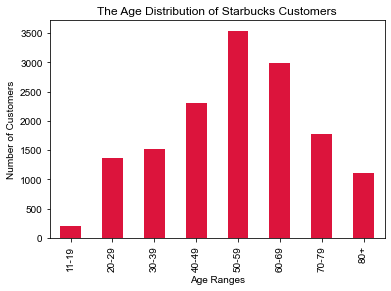

In [30]:
#Viewing the age ranges of our Stabucks customers
profile['age_range'].value_counts().sort_index().plot(kind = 'bar', color = my_crimson_color);
plt.title('The Age Distribution of Starbucks Customers');
plt.style.use('seaborn');
plt.ylabel('Number of Customers');
plt.xlabel('Age Ranges');

### A1: The actual age distributions of Starbucks customers.
It would seem like that from the data shows that the largest purchaser seems to be in the 40's , 50's and 60's range which probably means that the starbucks have become an hangout spot for those close to retirement or already retired. This speaks to the fact that the older one gets , the more likey they are able to afford starbucks high steeped prices of coffee,This might be another reason. 

### Q2:What does the correlation between number of days an offer has been vs. final transaction amount have to tell us ?

The correlation might be that since an offer has been open fpr an extended period of time, The customer might not feel particularly that excited about it. A More enthuastic customer would have claimed the reward earlier, for fear of missing out on the reward.Lets move on and see what the data has to say about this concept

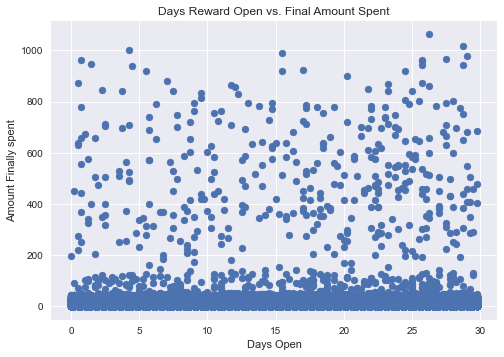

In [31]:
#Visualizing the days spent vs anount spent in a scatter plot
plt.scatter(data = transcript_amount, x = 'days', y = 'amount');
plt.title('Days Reward Open vs. Final Amount Spent');
plt.xlabel('Days Open');
plt.ylabel('Amount Finally spent');
plt.style.use('seaborn');

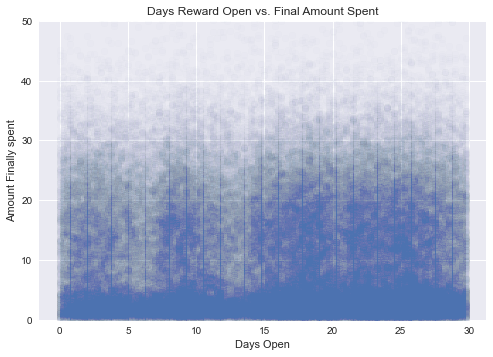

In [32]:
#Visualizing the days open vs amount spent in a scatter plot in a more limited view
plt.scatter(data = transcript_amount, x = 'days', y = 'amount', alpha = .01);
plt.title('Days Reward Open vs. Final Amount Spent');
plt.xlabel('Days Open');
plt.ylabel('Amount Finally spent');
plt.style.use('seaborn');
plt.ylim(0,50);

### A2: Analysis of amount spent vs. Days Open
There seems to be no correlation between thr amount spent and the days the offer was left open. This is clarified bu the two scacatter plots which shows there were no correlation between the two 


### Q3: Does gender have any effect on the data ?
Lets take a dive into how gender might have an effect on the videos. Our dataset have three indistinct genders: Male, Female, and Other

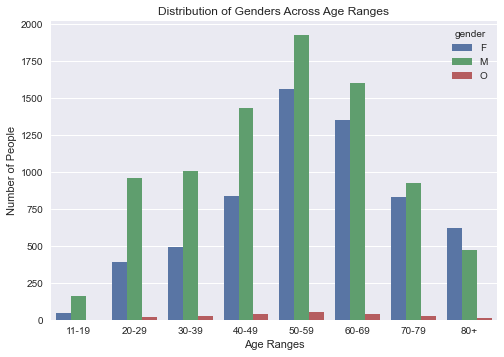

In [33]:
#Visualizing the gender distribution in a seaborn count plot
sb.countplot(data = profile,x = 'age_range', hue = 'gender')
plt.title('Distribution of Genders Across Age Ranges');
plt.xlabel('Age Ranges');
plt.ylabel('Number of People');
plt.style.use('seaborn');


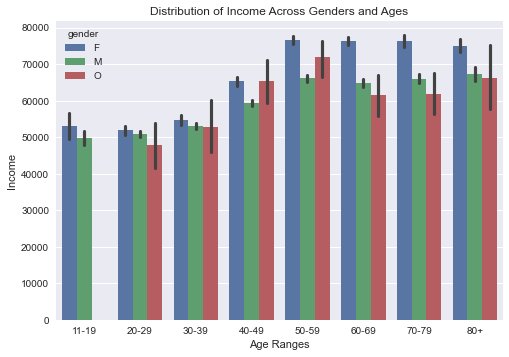

In [34]:
#Visualizing the gender/income/age range distribution in a seaborn bar plot
sb.barplot(data = profile, x = 'age_range', y = 'income', hue = 'gender');
plt.title('Distribution of Income Across Genders and Ages');
plt.xlabel('Age Ranges');
plt.ylabel('Income');
plt.style.use('seaborn');

### A3: Analysis of gender across our customer data
The first plot did not suprise me at all , i had a feeling that since its the general sentiment that men made more money, then its only normal the had more income,However the second plot nullifies that point and shows that women had higher income on average across the age ranges, even though there was not much disparity between the income ranges.I was really suprised by this plot reaction

### Q4: What are the salary ranges of people across different age groups

I wanted to see how the salary ranges of these various age groups might affect how often a person visits Starbucks and use their rewards program. My hypothesis is that the older you are the higher you earn and are more likely to buy more


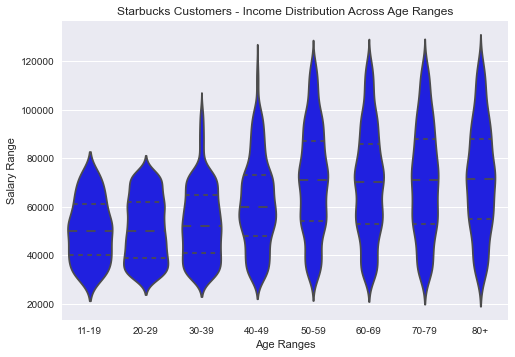

In [35]:
#Visualizing the data in a violin plot
sb.violinplot(data = profile, x = 'age_range', y = 'income', color = my_blue_color, inner = 'quartile');
plt.title('Starbucks Customers - Income Distribution Across Age Ranges');
plt.xlabel('Age Ranges')
plt.ylabel('Salary Range')
plt.style.use('seaborn')

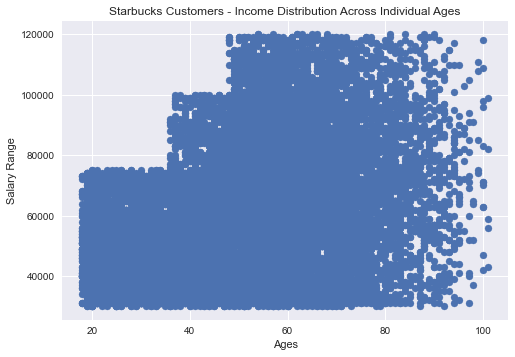

In [36]:
#Visualizing the data in a scatter plot using individual ages instead of age ranges
plt.scatter(data = profile, x = 'age', y = 'income');
plt.title('Starbucks Customers - Income Distribution Across Individual Ages');
plt.xlabel('Ages');
plt.ylabel('Salary Range');
plt.style.use('seaborn');

 ### A4: Analysis of Income Distribution
 When visualizing the data with the violin plots, My hypothesis was confirmed  that older customers definitely tend to make more money;There seemed to be an hard cap at 80,000 on the salary range for young people while for old people the hard cap its 120,000. I think the problem is that i know people in thier 20's and 30's don't have that salary cap so that might be as a result of the data gathered 
 

##  


### Data Preprocessing

With initial analysis / clean up and EDA under our belt, let's move on into formalizing some data preprocessing before we move into modeling the data with some unsupervised models. First, we'll formalize what we already did above for our individual dataset into their own respective functions, and next, we'll start combining these datasets appropriately given our insights gleaned from our exploratory data analysis.


In [3]:
#Function to clean up portfolio

def clean_portfolio(portfolio = portfolio):
    #Changing the column name from 'id' to 'offer_id'
    portfolio.rename(columns = {'id': 'offer_id'}, inplace = True)
    
    #One hot encoding the offer_type field, fixing a prefix of 'offer'
    offer_dummies = pd.get_dummies(portfolio['offer_type'], prefix = 'offer')
    portfolio = pd.concat([portfolio, offer_dummies], axis = 1)
    
    #Separating and one hot encoding the channels field
    channels_one_hot = MultiLabelBinarizer()
    sep_channels = channels_one_hot.fit_transform(portfolio['channels'])
    channels_df = pd.DataFrame(data = sep_channels, columns = channels_one_hot.classes_)
    portfolio = pd.concat([portfolio, channels_df], axis = 1)
    portfolio.rename(columns = {'email': 'channel_email', 'mobile': 'channel_mobile', 'social': 'channel_social', 'web': 'channel_web'}, inplace = True)
    
    #Dropping the now former columns
    portfolio.drop(columns = ['channels', 'offer_type'], axis = 1, inplace = True)
    
    return portfolio

portfolio_clean = clean_portfolio()
portfolio_clean.head()
    

,reward,difficulty,duration,offer_id,offer_bogo,offer_discount,offer_informational,channel_email,channel_mobile,channel_social,channel_web
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,1,1,1,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,1,1,1,1
2,0,0,4,3f207df678b143eea3cee63160fa8bed,0,0,1,1,1,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,1,1,0,1
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1,0,0,1


In [4]:
#Function to clean up profile
def clean_profile(profile = profile):
    #Dropping rows with null information
    profile.dropna(inplace = True)
    
    #Changing 'id' column name to more appropriate 'customer_id' name
    profile.rename(columns = {'id': 'customer_id'}, inplace = True)
    
    #Changing 'became_member_on' column to a date type
    profile['became_member_on'] = profile['became_member_on'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d').date())
    
    #Calculating number of days as a member ending on August 1, 2018 in new column 'days_as_member'
    end_date = pd.Timestamp('2018-08-01')
    end_date = pd.to_datetime(end_date)
    profile['days_as_member'] = np.abs((pd.to_datetime(profile['became_member_on']) - end_date).dt.days)
    
    #Creating 'age_range' column based on 'age'
    age_range_labels = ['11-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
    age_range_bins = [11, 20, 30, 40, 50, 60, 70, 80, 110]
    profile['age_range'] = pd.cut(profile['age'], bins = age_range_bins, labels = age_range_labels, right = False)

    #Adding a specific order to the age_range_field
    profile['age_range'] = pd.Categorical(profile['age_range'], ordered = True, categories = age_range_labels)
    return profile

profile_clean = clean_profile()
profile_clean.head()

,gender,age,customer_id,became_member_on,income,days_as_member,age_range
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,382,50-59
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,449,70-79
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,97,60-69
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,173,60-69
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,263,50-59


In [5]:
#Function to clean up transcript
def clean_transcript(transcript = transcript):
    #Changing the 'person' category name to 'customer_id'
    transcript.rename(columns = {'person': 'customer_id'}, inplace = True)
    
    #Remove customers not found in the 'profile dataset'
    transcript = pd.merge(left = transcript, right = profile, how = 'inner', left_on = 'customer_id', right_on = 'customer_id')
    transcript.drop(columns = ['age', 'became_member_on', 'gender', 'income', 'days_as_member', 'age_range'], inplace = True)
    
    #One hot encode event values
    event_dummies = pd.get_dummies(transcript['event'])
    event_dummies.rename(columns = {'offer completed': 'offer_completed', 'offer received': 'offer_received', 'offer viewed': 'offer_viewed'}, inplace = True)
    transcript = pd.concat([transcript, event_dummies], axis = 1)
    
    #Change 'time' column to 'days' along with the appropriate values
    transcript['days'] = transcript['time'] / 24
    transcript.drop(columns = ['time'], inplace = True)
    
    #Separate value from key in 'value' dictionary to form two new DataFrames: transcript_offer and transcript_amount

    #Initial separation
    transcript['offer-or-amount'] = transcript['value'].apply(lambda x: list(x.keys())[0])
    transcript['id-or-amount'] = transcript['value'].apply(lambda x: list(x.values())[0])

    #Conforming 'offer id' to read 'offer_id' consistently
    trans_offer_dict = {'offer id': 'offer_id'}
    transcript['offer-or-amount'].replace(trans_offer_dict, inplace = True)

    #Creating the transcript_offer DataFrame
    transcript_offer = transcript[transcript['offer-or-amount'] == 'offer_id']
    transcript_offer.rename(columns = {'id-or-amount': 'offer_id'}, inplace = True)
    transcript_offer.drop(columns = ['event', 'value', 'offer-or-amount', 'transaction'], inplace = True)

    #Creating the transcript_amount DataFrame
    transcript_amount = transcript[transcript['offer-or-amount'] == 'amount']
    transcript_amount.rename(columns = {'id-or-amount': 'amount'}, inplace = True)
    transcript_amount.drop(columns = ['event', 'value', 'offer-or-amount', 'offer_completed', 'offer_received', 'offer_viewed'], inplace = True)

    return transcript_offer, transcript_amount

transcript_offer_clean, transcript_amount_clean = clean_transcript()
print(transcript_offer_clean)
print(transcript_amount_clean)

C:\Users\HP\Anaconda3\lib\site-packages\pandas\core\frame.py:4446: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\HP\Anaconda3\lib\site-packages\pandas\core\frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


                             customer_id  offer_completed  offer_received  \
0       78afa995795e4d85b5d9ceeca43f5fef                0               1   
1       78afa995795e4d85b5d9ceeca43f5fef                0               0   
3       78afa995795e4d85b5d9ceeca43f5fef                1               0   
5       78afa995795e4d85b5d9ceeca43f5fef                0               1   
6       78afa995795e4d85b5d9ceeca43f5fef                0               0   
...                                  ...              ...             ...   
272757  9fcbff4f8d7241faa4ab8a9d19c8a812                0               0   
272758  9fcbff4f8d7241faa4ab8a9d19c8a812                0               1   
272759  9fcbff4f8d7241faa4ab8a9d19c8a812                0               0   
272760  3045af4e98794a04a5542d3eac939b1f                0               1   
272761  3045af4e98794a04a5542d3eac939b1f                0               0   

        offer_viewed   days                          offer_id  
0          

In [ ]:
channels = np.unique([channel for chans in portfolio['channels'].items() for channel in chans[1]])

In [ ]:
profile.info()

In [ ]:
df1 = portfolio.copy()

In [ ]:
dummy = pd.get_dummies(df1.channels.apply(pd.Series).stack().sum(level = 0))
df1 = pd.concat([df1,dummy],axis = 1)
df1 = df1.drop(columns = 'channels')

In [ ]:
df1 =df1.rename(columns={'id':'offer_id'}) 
df1

In [ ]:
portfolio.head()

In [ ]:
portfolio['channels']